In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

#run all locally to access cplex

import pandas as pd
import numpy as np
#from tqdm import tqdm
#import libsbml
from six import string_types
import scipy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First option toy matrix- completely synthetic

from flux network paper <br>
$RAG = \hat{S}^T\hat{S}$ where $\hat{S} =$ bipartite graph associated with boolean stoichiometry matrix

> - according to text, reaction 8 is biomass <br>
> - like e. coli, not listed with any gene associations

In [ ]:
S_toy =np.array([[1, -1, 0, 0, 0, 0, 0, 0], 
                  [0, 1, -1, -1, 0, 0, 0, 0], 
                  [0, 0, 1, 0, -1, 0, 0, -1], 
                  [0, 0, 0, 1, 0, -1, -1, -2],
                  [0, 0, 0, 0, 1, 1, 0, -1]])

In [ ]:
S_hat = np.array(S_toy.astype(bool).astype(int))

In [ ]:
reactions = np.array([str("R" + str(i)) for i in range(1,9)])
metabolites = np.array([str("M" + str(i)) for i in range(1,6)])

In [ ]:
S_toy = pd.DataFrame(S_toy, columns = reactions, index = metabolites)

In [ ]:
RAG = pd.DataFrame(np.matmul(S_hat.transpose(), S_hat), columns = reactions, index = reactions)

In [ ]:
RAG

,R1,R2,R3,R4,R5,R6,R7,R8
R1,1,1,0,0,0,0,0,0
R2,1,2,1,1,0,0,0,0
R3,0,1,2,1,1,0,0,1
R4,0,1,1,2,0,1,1,1
R5,0,0,1,0,2,1,0,2
R6,0,0,0,1,1,2,1,2
R7,0,0,0,1,0,1,1,1
R8,0,0,1,1,2,2,1,3


In [ ]:
RAG.to_csv("toy_adjacency_matrix.csv", index = True)

In [ ]:
S_toy

,R1,R2,R3,R4,R5,R6,R7,R8
M1,1,-1,0,0,0,0,0,0
M2,0,1,-1,-1,0,0,0,0
M3,0,0,1,0,-1,0,0,-1
M4,0,0,0,1,0,-1,-1,-2
M5,0,0,0,0,1,1,0,-1


In [ ]:
!pip install graphtools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import graphtools
import networkx as nx 

In [ ]:
RAG = np.array(RAG.astype(bool).astype(int))

In [ ]:
G_RAG = nx.Graph()
for i in range(RAG.shape[0]): 
    for j in range( RAG.shape[1]): 
        if RAG[i][j] == 1: 
            G_RAG.add_edge(i,j) 

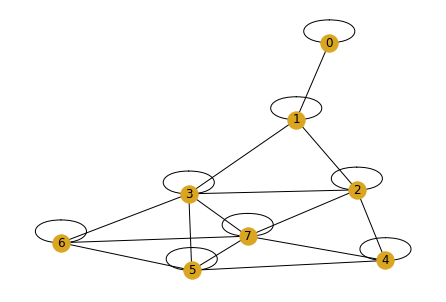

In [ ]:
#reaction 8 (lab 7) is biomass according to paper
nx.draw_spring( G_RAG, node_color = "goldenrod", with_labels = True) 
plt.show() 

In [ ]:
def directed_adj_matrix(S_mat) :
    #N reactions
    M = S_mat.shape[1]
    #M metabolites
    N = S_mat.shape[0]
    
    D_Adj = np.zeros([M, M])
    
    #for each reaction 
    for i in range(0,M):
        for met in range(0,N):
            if S_mat.iloc[met,i] > 0:
                for j in range(0,M):
                    if S_mat.iloc[met,j] < 0:
                        D_Adj[i,j] = 1
    return D_Adj

In [ ]:
DA_pos = directed_adj_matrix(S2m_pos)
DA_neg = directed_adj_matrix(S2m_neg)

NameError: ignored

In [ ]:
G_dRAG = nx.DiGraph()
for i in range(DA_pos.shape[0]): 
    for j in range( DA_pos.shape[1]): 
        if DA_pos[i][j] == 1: 
            G_dRAG.add_edge(i,j) 
for i in range(DA_neg.shape[0]): 
    for j in range( DA_neg.shape[1]): 
        if DA_neg[i][j] == 1: 
            G_dRAG.add_edge(j,i) 

NameError: name 'DA_pos' is not defined

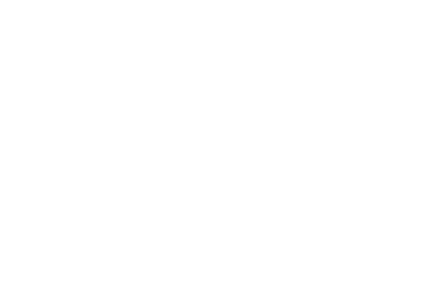

In [ ]:
nx.draw( G_dRAG, node_color = "goldenrod",with_labels = True) 
plt.show() 

# Linear Constraints

In [ ]:
lb = (1, 0, 0, -10, 0, 0, 0, 0) #1 reversible reaction- uptake cannot be zero
ub = np.repeat(10, 8)

#r1 required- uptake reaction
#r4 == reversible (index 9 is reaction 4 reversed)

In [ ]:
enzymes = np.array([str("E" + str(i)) for i in range(1,13)])

In [ ]:
#enzymes x reactions (reaction mapping)
catalysis = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0 ,0],
                      [0, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0], 
                      [0, 0, 0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0]]) #switched here

In [ ]:
reaction_mapping = pd.DataFrame(catalysis, index = enzymes, columns= reactions)

In [ ]:
#number enzymes required for each reaction
np.sum(catalysis, axis= 0)

array([1, 2, 3, 1, 1, 2, 2, 0])

In [ ]:
#autoscale to 1
np.random.seed(4)
tx = np.random.rand(reaction_mapping.shape[0], 100)

In [ ]:
exp_lev = np.transpose(np.transpose(reaction_mapping) * tx[:,0])

In [ ]:
exp_lev

,R1,R2,R3,R4,R5,R6,R7,R8
E1,0.96703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
E2,0.00000,0.260922,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
E3,0.00000,0.230746,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
E4,0.00000,0.000000,0.723733,0.000000,0.000000,0.000000,0.000000,0.0
E5,0.00000,0.000000,0.324422,0.000000,0.000000,0.000000,0.000000,0.0
E6,0.00000,0.000000,0.879618,0.000000,0.000000,0.000000,0.000000,0.0
E7,0.00000,0.000000,0.000000,0.258309,0.000000,0.000000,0.000000,0.0
E8,0.00000,0.000000,0.000000,0.000000,0.043205,0.000000,0.000000,0.0
E9,0.00000,0.000000,0.000000,0.000000,0.000000,0.433894,0.000000,0.0
E10,0.00000,0.000000,0.000000,0.000000,0.000000,0.518690,0.000000,0.0


In [ ]:
import numpy.ma as ma
mx = ma.masked_array(exp_lev, mask=exp_lev==0)
reaction_expression = np.array([mx[:,i].min() for i in range(0, mx.shape[1])])

In [ ]:
#set biomass- uncatalyzed to 1
reaction_expression[7] = 1

In [ ]:
reaction_expression

array([0.96702984, 0.23074594, 0.32442159, 0.25830878, 0.0432055 ,
       0.43389385, 0.65838528, 1.        ])

## setup CPLEX problem

In [ ]:
!pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cplex

In [ ]:
#initialize_cplex_problem
problem = cplex.Cplex()
problem.set_log_stream(None)  # Suppress output
problem.set_error_stream(None)  # Suppress errors
problem.set_warning_stream(None)  # Suppress Warnings
problem.set_results_stream(None)  # Suppress results to output

problem.parameters.emphasis.numerical.set(True) #changed from compass True
problem.parameters.threads.set(10)
problem.parameters.preprocessing.reduce.set(3) #Turning on primal and dual preprocessing also enables some reoptimization features
problem.parameters.advance.set(0) #Will presolve advanced basis again
#problem.parameters.barrier.convergetol.set(1e-12) #default is 1e-8, minimum is 1e-12.
problem.parameters.lpmethod.set(4) #default lets CPLEX choose the method



In [ ]:
lb = np.array([1, 1, 1, -10, 1, 1, 1, 1], dtype= int)
ub = np.repeat(10, 8)

In [ ]:
ub = reaction_expression * ub
lb = reaction_expression * lb

##contrain bounds by gene/reaction expression
#for dataset 0
problem.variables.add(
    names=list(reactions),
    ub= list(ub),
    lb= list(lb))

range(0, 8)

In [ ]:
#need to generate lin_exp dictionary
#{'metabolite': [(rxn, stoichiometry)], [rxn, stoichiometry], ... }

s_list = {}

for i, metab in enumerate(S_toy.index):
    for j, rxn in enumerate(S_toy.columns):
        if S_toy.iloc[i, j] == 0:
            next
        elif metab not in s_list:
            s_list[metab] = [(rxn, S_toy.iloc[i,j])]
       
        else:
            s_list[metab].append((rxn, S_toy.iloc[i,j]))

In [ ]:
lin_exp = []
senses = []
rhs = []
names = []

for metab, rx in s_list.items():
    if len(rx) == 0:
        continue
    #ind is reaction
    ind = [x[0] for x in rx]
    val = [int(x[1]) for x in rx]
    lin_exp.append(cplex.SparsePair(ind=ind, val=val))
    
    senses.append("E")
    rhs.append(0)
    names.append(metab)

In [ ]:
#mass balance constraints
problem.linear_constraints.add(
        lin_expr=lin_exp,
        senses=senses,
        rhs=rhs,
        names=names)

range(0, 5)

In [ ]:
#just optimize for flux through pathway?
problem.objective.set_linear(reactions[7], 1)
problem.objective.set_sense(problem.objective.sense.maximize)
problem.solve()

## Do for multiple tx (generated randomly)

In [ ]:
#autoscale to 1
np.random.seed(4)
tx = np.random.rand(reaction_mapping.shape[0], 1000)

In [ ]:
tx[:,4]

array([0.69772882, 0.26004544, 0.19180018, 0.64677895, 0.67659224,
       0.04829606, 0.66492283, 0.0132311 , 0.10562536, 0.0263569 ,
       0.43155528, 0.1947222 ])

In [ ]:
import numpy.ma as ma

In [ ]:
#need to generate lin_exp dictionary
#{'metabolite': [(rxn, stoichiometry)], [rxn, stoichiometry], ... }

s_list = {}

for i, metab in enumerate(S_toy.index):
    for j, rxn in enumerate(S_toy.columns):
        if S_toy.iloc[i, j] == 0:
            next
        elif metab not in s_list:
            s_list[metab] = [(rxn, S_toy.iloc[i,j])]
       
        else:
            s_list[metab].append((rxn, S_toy.iloc[i,j]))

In [ ]:
lin_exp = []
senses = []
rhs = []
names = []

for metab, rx in s_list.items():
    if len(rx) == 0:
        continue
    #ind is reaction
    ind = [x[0] for x in rx]
    val = [int(x[1]) for x in rx]
    lin_exp.append(cplex.SparsePair(ind=ind, val=val))
    
    senses.append("E")
    rhs.append(0)
    names.append(metab)

In [ ]:
solutions = {}
max_values = {}
reaction_exp = {}

In [ ]:
for i in range(0, tx.shape[1]):
    
    exp_lev = np.transpose(np.transpose(reaction_mapping) * tx[:,i])
    mx = ma.masked_array(exp_lev, mask=exp_lev==0)
    reaction_expression = np.array([mx[:,i].min() for i in range(0, mx.shape[1])])
    #1 for uncatalyzed biomass reaction
    reaction_expression[7] = 1
    
    #initialize_cplex_problem
    #initialize_cplex_problem
    problem = cplex.Cplex()
    problem.set_log_stream(None)  # Suppress output
    problem.set_error_stream(None)  # Suppress errors
    problem.set_warning_stream(None)  # Suppress Warnings
    problem.set_results_stream(None)  # Suppress results to output

    problem.parameters.emphasis.numerical.set(True) #changed from compass True
    problem.parameters.threads.set(10)
    problem.parameters.preprocessing.reduce.set(3) #Turning on primal and dual preprocessing also enables some reoptimization features
    problem.parameters.advance.set(0) #Will presolve advanced basis again
    #problem.parameters.barrier.convergetol.set(1e-12) #default is 1e-8, minimum is 1e-12.
    problem.parameters.lpmethod.set(4) #default lets CPLEX choose the method
    
    lb = np.array([1, 0, 0, -10, 0, 0, 0, 0], dtype= int)
    ub = np.repeat(10, 8)
    
    ub = reaction_expression * ub
    lb = reaction_expression * lb

    ##contrain bounds by gene/reaction expression
    #for dataset 0
    problem.variables.add(
        names=list(reactions),
        ub= list(ub),
        lb= list(lb))
    
    #mass balance constraints
    problem.linear_constraints.add(
            lin_expr=lin_exp,
            senses=senses,
            rhs=rhs,
            names=names)
    
    problem.objective.set_linear(reactions[7], 1)
    problem.objective.set_sense(problem.objective.sense.maximize)
    
    
    #randomly generated, may be some that make no sense
    try:
    # block raising an exception
        problem.solve()
        solutions[i] = problem.solution.get_values()
        max_values[i] = problem.solution.get_objective_value()
        reaction_exp[i] = reaction_expression
    except:
        pass
    

    
    
    
    
    

In [ ]:
len(list(reaction_exp.keys()))

892

In [ ]:
np.min(list(max_values.values()))

0.002266675538222518

In [ ]:
#check solution length 
s=0
for i, sol in enumerate(solutions.values()):
    sv = np.matmul(S_toy, list(solutions.values())[0])
    if np.sum(sv) > 0:
        print("error", i, np.sum(sv))
        
    if i+1 == len(list(solutions.values())):
        print(f'END: all {i+1} solutions satisfy constraints')

END: all 892 solutions satisfy constraints


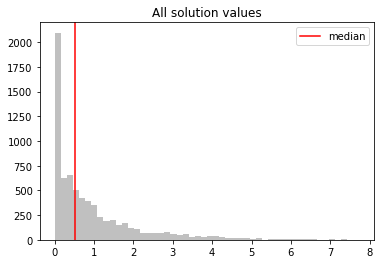

In [ ]:
plt.hist(np.concatenate(list(solutions.values())), bins= 50, color= 'silver')
plt.title("All solution values")
plt.axvline(np.median(list(solutions.values())), color= 'red', label= "median")
plt.legend()
plt.show()

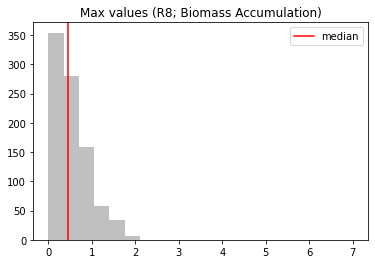

In [ ]:
plt.hist(list(max_values.values()), bins= 20, range=(0, 7), color= 'silver')
plt.title("Max values (R8; Biomass Accumulation)")
plt.axvline(np.median(list(max_values.values())), color= 'red', label= "median")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

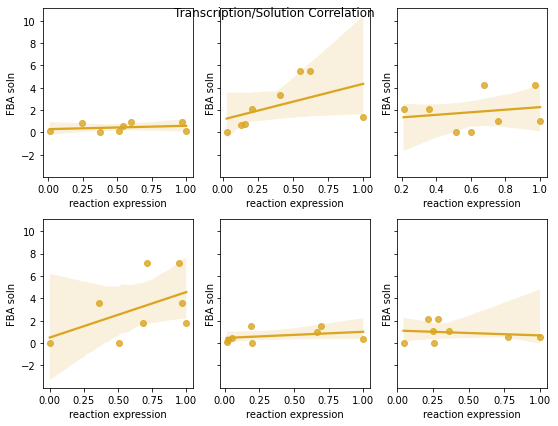

In [ ]:
import warnings
warnings.filterwarnings('ignore') #turn warnings off temporarily 

fig, axs = plt.subplots(2, 3, figsize=(8, 6), sharey=True)
fig.suptitle("Transcription/Solution Correlation")

for i, ax in enumerate(axs.flatten()):

    n=i

    exp_lev = np.transpose(np.transpose(reaction_mapping) * tx[:,n])
    mx = ma.masked_array(exp_lev, mask=exp_lev==0)
    reaction_expression = np.array([mx[:,i].min() for i in range(0, mx.shape[1])])
    #1 for uncatalyzed biomass reaction
    reaction_expression[7] = 1
    
    x = reaction_expression
    y = list(solutions.values())[n]
    
    m, b = np.polyfit(x, y, 1)


    ax = sns.regplot(x, y, ax= ax, color= 'goldenrod')
    ax.set_xlabel("reaction expression")
    ax.set_ylabel("FBA soln")
    
fig.tight_layout()

warnings.filterwarnings('default') #turn warnings back on 


## generate graphs from solutions

In [ ]:
graphs = {}
graphs_F = {}
graphs_R = {}

In [ ]:
revers_vector = np.array([0, 0, 0, 1, 0, 0, 0, 0])

IM = np.identity(S_toy.shape[1])
R = np.diag(revers_vector)

${\dot{\mathbf x}} = {\mathbf{Sv}} = \underbrace {\left[ {\begin{array}{*{20}{c}} {\mathbf{S}} & { - {\mathbf{S}}} \end{array}} \right]\left[ {\begin{array}{*{20}{c}} {{\mathbf{I}}_m} & 0 \cr 0 & {{\mathrm{diag}}\left( {\mathbf{r}} \right)} \end{array}} \right]}_{{\mathbf{S}}_{2m}}\left[ {\begin{array}{*{20}{c}} {{\mathbf{v}}^ + } \cr {{\mathbf{v}}^ - } \end{array}} \right]: = {\mathbf{S}}_{2m}{\kern 1pt} {\mathbf{v}}_{2m}{\kern 1pt}$

$\begin{array}{*{20}{l}} {{\mathrm{Production:}}\quad } \hfill & {{\mathbf{S}}_{2m}^ + = \frac{1}{2}\left( {{\mathrm{abs}}\left( {{\mathbf{S}}_{2m}} \right) + {\mathbf{S}}_{2m}} \right)} \hfill \cr {{\mathrm{Consumption:}}\quad } \hfill & {{\mathbf{S}}_{2m}^ - = \frac{1}{2}\left( {{\mathrm{abs}}\left( {{\mathbf{S}}_{2m}} \right) - {\mathbf{S}}_{2m}} \right),} \hfill \end{array}$

In [ ]:
S2m_pos = (S_toy + np.abs(S_toy))/2 #production
S2m_neg = (S_toy - np.abs(S_toy))/2 #consumption

In [ ]:
np.matmul(S2m_pos, v) + np.matmul(S2m_neg, v)

M1    0.0
M2    0.0
M3    0.0
M4    0.0
M5    0.0
dtype: float64

## same until here (NFG, MFG)

In [ ]:
v = list(solutions.values())[1]

${\mathbf{v}}_{2m}^ \ast = \left[ {\begin{array}{*{20}{c}} {{\mathbf{v}}^{ \ast + }} \cr {{\mathbf{v}}^{ \ast - }} \end{array}} \right] = \frac{1}{2}\left[ {\begin{array}{*{20}{c}} {{\mathrm{abs}}\left( {{\mathbf{v}}^ \ast } \right) + {\mathbf{v}}^ \ast } \cr {{\mathrm{abs}}\left( {{\mathbf{v}}^ \ast } \right) - {\mathbf{v}}^ \ast } \end{array}} \right],$

In [ ]:
v

[5.4723224917572235,
 5.4723224917572235,
 2.1002727205692837,
 3.37204977118794,
 0.7321920976299778,
 0.635888525309328,
 0.0,
 1.3680806229393059]

In [ ]:
v2m_pos = (v + np.abs(v))/2
v2m_neg = (v - np.abs(v))/2

vp = np.array([[v2m_pos], [v2m_neg]])

${\mathbf{j}}({\mathbf{v}}^ \ast ) = {\mathbf{S}}_{2m}^ + {\mathbf{v}}_{2m}^ \ast = {\mathbf{S}}_{2m}^ - {\mathbf{v}}_{2m}^ \ast .$

In [ ]:
jv = np.matmul(S2m_pos, v) #amount of metabolites flowing
Jv = np.array([np.matmul(S2m_pos, v2m_pos), np.matmul(S2m_pos, v2m_neg)])

${\mathrm{Mass}}\,{\mathrm{Flow}}\,{\mathrm{Graph}}\,\left( {{\mathrm{MFG}}} \right):\quad {\mathbf{M}}\left( {{\bf{v}}^ \ast } \right) = \left( {{\mathbf{S}}_{2m}^ + {\bf{V}}^ \ast } \right)^T{\mathbf{J}}_v^\dagger \left( {{\mathbf{S}}_{2m}^ - {\bf{V}}^ \ast } \right),$

where: ${\bf{V}}^ \ast = {\mathrm{diag}}\left( {{\bf{v}}_{2m}^ \ast } \right)$<br>
${\mathrm{J}}_{v}={\mathrm{diag}} ({\rm{j}}({{\mathrm{v}}^{*}))}$ <br>
$\dagger$ denotes moore-penrose pseudoinverse

In [ ]:
J = np.array([np.linalg.pinv(np.diag(np.array(Jv[0]))), np.linalg.pinv(np.diag(np.array(Jv[1])))])

#v2m_ needs to be made a diag matrix
L = np.array([np.matmul(S2m_pos, np.diag(v2m_pos)).T, np.matmul(S2m_pos, np.diag(v2m_neg)).T])

R = np.array([np.matmul(S2m_neg, np.diag(v2m_pos)), np.matmul(S2m_neg, np.diag(v2m_neg))])

MFG = pd.DataFrame(np.abs(np.matmul(L, np.matmul(J, R))[0]))


In [ ]:
pd.DataFrame(MFG)

,0,1,2,3,4,5,6,7
0,0.0,5.472322,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
1,0.0,0.000000,2.100273,3.37205,0.000000,0.000000,0.0,0.000000
2,0.0,0.000000,0.000000,0.00000,0.732192,0.000000,0.0,1.368081
3,0.0,0.000000,0.000000,0.00000,0.000000,0.635889,0.0,2.736161
4,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.732192
5,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.635889
6,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
7,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000


# Iterate

In [ ]:
graphs = {}
graphs_F = {}
graphs_R = {}

In [ ]:
for i, sol in enumerate(list(solutions.items())):
    v = sol[1]
    
    v2m_pos = (v + np.abs(v))/2
    v2m_neg = (v - np.abs(v))/2
    
    vp = np.array([[v2m_pos], [v2m_neg]])
    
    jv = np.matmul(S2m_pos, v) #amount of metabolites flowing
    Jv = np.array([np.matmul(S2m_pos, v2m_pos), np.matmul(S2m_pos, v2m_neg)])
    
    J = np.array([np.linalg.pinv(np.diag(np.array(Jv[0]))), np.linalg.pinv(np.diag(np.array(Jv[1])))])
    L = np.array([np.matmul(S2m_pos, np.diag(v2m_pos)).T, np.matmul(S2m_pos, np.diag(v2m_neg)).T])
    R = np.array([np.matmul(S2m_neg, np.diag(v2m_pos)), np.matmul(S2m_neg, np.diag(v2m_neg))])
    
    F_g = np.abs(np.matmul(L, np.matmul(J, R))[0])
    R_g = np.abs(np.matmul(L, np.matmul(J, R))[1])
    
    MFG = F_g + R_g
    
    graphs_F[i] = F_g
    graphs_R[i] = R_g
    graphs[sol[0]] = MFG
    
    
    

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


> was issue with S2m matrix (F/R vs. Prod/Cons) <br>
> <u>Biomass pathways: 
> - 0 > 1 > 2 > 4 > 7
> - 0 > 1 > 3 > 7
> - 0 > 1 > 3 > 5 > 7

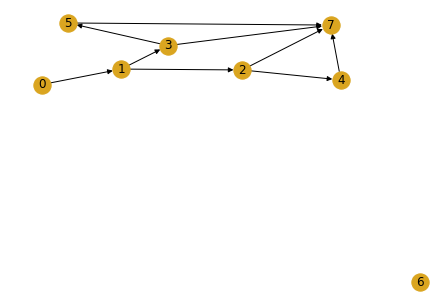

In [ ]:
warnings.filterwarnings('ignore')
G = nx.from_numpy_matrix(np.matrix(graphs[1]), create_using=nx.DiGraph)
nx.draw(G, node_color = "goldenrod", with_labels = True)
plt.show()

In [ ]:
'''for i in range(0,11):
    gn = list(graphs.keys())[i]
    G = nx.from_numpy_matrix(np.matrix(graphs[gn]), create_using=nx.DiGraph)
    nx.draw(G, node_color = "goldenrod", with_labels = True)
    plt.show()'''

'for i in range(0,11):\n    gn = list(graphs.keys())[i]\n    G = nx.from_numpy_matrix(np.matrix(graphs[gn]), create_using=nx.DiGraph)\n    nx.draw(G, node_color = "goldenrod", with_labels = True)\n    plt.show()'

In [ ]:
'''gr = nx.from_numpy_matrix(graphs[0], create_using = nx.DiGraph)
weights = nx.get_edge_attributes(gr, 'weight')
all_rows = range(0, graphs[0].shape[0])
for n in all_rows:
    gr.add_node(n)
edges = gr.edges
scaling_factor = 3
alphas = [weights[edge] * scaling_factor for edge in edges]
pos = nx.spring_layout(gr, weight = 'my_weight')
nx.draw(gr, pos= pos, node_color= "goldenrod", with_labels = True, width= alphas)'''

'gr = nx.from_numpy_matrix(graphs[0], create_using = nx.DiGraph)\nweights = nx.get_edge_attributes(gr, \'weight\')\nall_rows = range(0, graphs[0].shape[0])\nfor n in all_rows:\n    gr.add_node(n)\nedges = gr.edges\nscaling_factor = 3\nalphas = [weights[edge] * scaling_factor for edge in edges]\npos = nx.spring_layout(gr, weight = \'my_weight\')\nnx.draw(gr, pos= pos, node_color= "goldenrod", with_labels = True, width= alphas)'

In [ ]:
'''for i in range(0,11):
    gn = list(graphs.keys())[i]
    gr = nx.from_numpy_matrix(graphs[gn], create_using = nx.DiGraph)
    weights = nx.get_edge_attributes(gr, 'weight')
    all_rows = range(0, graphs[0].shape[0])
    for n in all_rows:
        gr.add_node(n)
    edges = gr.edges
    scaling_factor = 3
    alphas = [weights[edge] * scaling_factor for edge in edges]
    pos = nx.spring_layout(gr, weight = 'my_weight')
    nx.draw(gr, pos= pos, node_color= "goldenrod", with_labels = True, width= alphas)
    plt.show()'''

'for i in range(0,11):\n    gn = list(graphs.keys())[i]\n    gr = nx.from_numpy_matrix(graphs[gn], create_using = nx.DiGraph)\n    weights = nx.get_edge_attributes(gr, \'weight\')\n    all_rows = range(0, graphs[0].shape[0])\n    for n in all_rows:\n        gr.add_node(n)\n    edges = gr.edges\n    scaling_factor = 3\n    alphas = [weights[edge] * scaling_factor for edge in edges]\n    pos = nx.spring_layout(gr, weight = \'my_weight\')\n    nx.draw(gr, pos= pos, node_color= "goldenrod", with_labels = True, width= alphas)\n    plt.show()'

# for xitong

In [ ]:
len(list(graphs.items()))

892

In [ ]:
import pickle

In [ ]:
with open('1_toy_graphs.pickle', 'wb') as handle:
    pickle.dump(graphs, handle)

In [ ]:
with open('1_node_features.pickle', 'wb') as handle:
    pickle.dump(reaction_exp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def directed_adj_matrix(S_mat) :
    #N reactions
    M = S_mat.shape[1]
    #M metabolites
    N = S_mat.shape[0]
    
    D_Adj = np.zeros([M, M])
    
    #for each reaction 
    for i in range(0,M):
        for met in range(0,N):
            if S_mat.iloc[met,i] > 0:
                for j in range(0,M):
                    if S_mat.iloc[met,j] < 0:
                        D_Adj[i,j] = 1
    return D_Adj

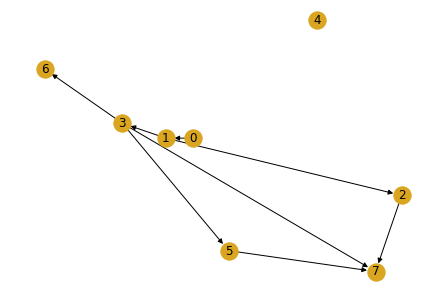

In [ ]:
G = nx.from_numpy_matrix(np.matrix(graphs[0]), create_using=nx.DiGraph)
nx.draw(G, node_color = "goldenrod", with_labels = True)
plt.show()

# weighted, directed

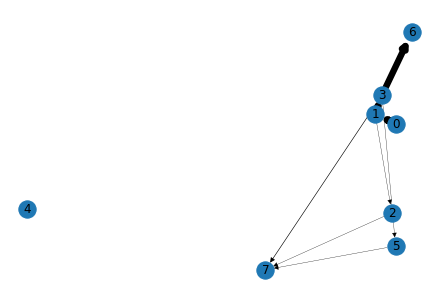

In [ ]:
gr = nx.from_numpy_matrix(graphs[0], create_using = nx.DiGraph)
weights = nx.get_edge_attributes(gr, 'weight')
all_rows = range(0, graphs[0].shape[0])
for n in all_rows:
    gr.add_node(n)
edges = gr.edges
scaling_factor = 3
alphas = [weights[edge] * scaling_factor for edge in edges]
nx.draw(gr, with_labels = True, width= alphas)

In [ ]:
gr

In [ ]:
pd.DataFrame(graphs[0])

,0,1,2,3,4,5,6,7
0,0.0,2.307459,0.00000,0.00000,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,1.15373,1.15373,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.00000,0.00000,0.576865,0.0,0.0,0.576865
3,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,1.153730
4,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.576865
5,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000
6,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000
7,0.0,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000


> ## graph construction

# Second option toy network- central carbon metabolism

## <u>stoichiometries and reaction mapping from DOI:10.3389/fphys.2015.00413

In [ ]:
metabolites = ('G6P','F6P','FDP','DHAP','G3P','13DPG','3PG','ATP','ADP','NADH',"NAD","H","Pi")
reactions = ('R1', "R2", 'R3', "R4", "R5", "R6")

In [ ]:
stoichiometries = np.array([[-1, 0, 0, 0, 0, 0], 
                           [1, -1, 0, 0, 0, 0], 
                           [0, 1, -1, 0, 0, 0], 
                           [0, 0, 1, -1, 0, 0],
                           [0, 0, 1, 1, -1, 0],
                           [0, 0, 0, 0, 1, -1],
                           [0, 0, 0, 0, 0, 1],
                           [0, -1, 0, 0, 0, 1],
                           [0, 1, 0, 0, 0, -1],
                           [0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, -1, 0],
                           [0, 1, 0, 0, 1, 0],
                           [0, 0, 0, 0, -1, 0]])

In [ ]:
#stoichiometry matrix
S_mat = pd.DataFrame(stoichiometries, columns = reactions, index = metabolites)

In [ ]:
S_mat

,R1,R2,R3,R4,R5,R6
G6P,-1,0,0,0,0,0
F6P,1,-1,0,0,0,0
FDP,0,1,-1,0,0,0
DHAP,0,0,1,-1,0,0
G3P,0,0,1,1,-1,0
13DPG,0,0,0,0,1,-1
3PG,0,0,0,0,0,1
ATP,0,-1,0,0,0,1
ADP,0,1,0,0,0,-1
NADH,0,0,0,0,1,0


In [ ]:
enzymes = ("pgi", "pfkA", "pfkB", "fbaA", "fbaB", "ydjl", "tpiA", "gapA", "pgk")

In [ ]:
catalysis = np.array([[1, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])

In [ ]:
#map transcription/enzymes to reactions
reaction_mapping = pd.DataFrame(catalysis, columns = reactions, index = enzymes)

In [ ]:
reaction_mapping

,R1,R2,R3,R4,R5,R6
pgi,1,0,0,0,0,0
pfkA,0,1,0,0,0,0
pfkB,0,1,0,0,0,0
fbaA,0,0,1,0,0,0
fbaB,0,0,1,0,0,0
ydjl,0,0,1,0,0,0
tpiA,0,0,0,1,0,0
gapA,0,0,0,0,1,0
pgk,0,0,0,0,0,1


In [ ]:
#randomly generate transcriptional states (implicitly [0,1] scaled)

##you can increase the size of the data to whatever you need, just add more columns to this matrix

tx = np.random.rand(reaction_mapping.shape[0], 100)

In [ ]:
tx[:,0]

array([0.4657139 , 0.78186504, 0.6437506 , 0.57603634, 0.72078581,
       0.61459941, 0.91409551, 0.8361512 , 0.82621721])

In [ ]:
exp_lev = np.transpose(np.transpose(reaction_mapping) * tx[:,0])

In [ ]:
exp_lev

,R1,R2,R3,R4,R5,R6
pgi,0.465714,0.000000,0.000000,0.000000,0.000000,0.000000
pfkA,0.000000,0.781865,0.000000,0.000000,0.000000,0.000000
pfkB,0.000000,0.643751,0.000000,0.000000,0.000000,0.000000
fbaA,0.000000,0.000000,0.576036,0.000000,0.000000,0.000000
fbaB,0.000000,0.000000,0.720786,0.000000,0.000000,0.000000
ydjl,0.000000,0.000000,0.614599,0.000000,0.000000,0.000000
tpiA,0.000000,0.000000,0.000000,0.914096,0.000000,0.000000
gapA,0.000000,0.000000,0.000000,0.000000,0.836151,0.000000
pgk,0.000000,0.000000,0.000000,0.000000,0.000000,0.826217


In [ ]:
exp_lev

,R1,R2,R3,R4,R5,R6
pgi,0.465714,0.000000,0.000000,0.000000,0.000000,0.000000
pfkA,0.000000,0.781865,0.000000,0.000000,0.000000,0.000000
pfkB,0.000000,0.643751,0.000000,0.000000,0.000000,0.000000
fbaA,0.000000,0.000000,0.576036,0.000000,0.000000,0.000000
fbaB,0.000000,0.000000,0.720786,0.000000,0.000000,0.000000
ydjl,0.000000,0.000000,0.614599,0.000000,0.000000,0.000000
tpiA,0.000000,0.000000,0.000000,0.914096,0.000000,0.000000
gapA,0.000000,0.000000,0.000000,0.000000,0.836151,0.000000
pgk,0.000000,0.000000,0.000000,0.000000,0.000000,0.826217


In [ ]:
import numpy.ma as ma
mx = ma.masked_array(exp_lev, mask=exp_lev==0)
reaction_expression = np.array([mx[:,i].min() for i in range(0, mx.shape[1])])

In [ ]:
#reversability of reactions
#boolean; 0 == irreversible, 1 == reversible
#all reactions in toy are irreversible

reversability_vector = np.array([0, 0, 0, 0, 0, 0])

## setup CPLEX problem

In [ ]:
import cplex

In [ ]:
#initialize_cplex_problem
problem = cplex.Cplex()
problem.set_log_stream(None)  # Suppress output
problem.set_error_stream(None)  # Suppress errors
problem.set_warning_stream(None)  # Suppress Warnings
problem.set_results_stream(None)  # Suppress results to output

problem.parameters.emphasis.numerical.set(True) #changed from compass True
problem.parameters.threads.set(10)
problem.parameters.preprocessing.reduce.set(3) #Turning on primal and dual preprocessing also enables some reoptimization features
problem.parameters.advance.set(0) #Will presolve advanced basis again
#problem.parameters.barrier.convergetol.set(1e-12) #default is 1e-8, minimum is 1e-12.
problem.parameters.lpmethod.set(4) #default lets CPLEX choose the method

In [ ]:
ub = reaction_expression * np.repeat(1000, 6)
lb = reaction_expression * np.repeat(0, 6)

##contrain bounds by gene/reaction expression
#for dataset 0
problem.variables.add(
    names=list(reactions),
    ub= list(ub),
    lb= list(lb))

range(0, 6)

In [ ]:
#need to generate lin_exp dictionary
#{'metabolite': [(rxn, stoichiometry)], [rxn, stoichiometry], ... }

s_list = {}

for i, metab in enumerate(S_mat.index):
    for j, rxn in enumerate(S_mat.columns):
        if S_mat.iloc[i, j] == 0:
            next
        elif metab not in s_list:
            s_list[metab] = [(rxn, S_mat.iloc[i,j])]
       
        else:
            s_list[metab].append((rxn, S_mat.iloc[i,j]))

In [ ]:
s_list

{'G6P': [('R1', -1)],
 'F6P': [('R1', 1), ('R2', -1)],
 'FDP': [('R2', 1), ('R3', -1)],
 'DHAP': [('R3', 1), ('R4', -1)],
 'G3P': [('R3', 1), ('R4', 1), ('R5', -1)],
 '13DPG': [('R5', 1), ('R6', -1)],
 '3PG': [('R6', 1)],
 'ATP': [('R2', -1), ('R6', 1)],
 'ADP': [('R2', 1), ('R6', -1)],
 'NADH': [('R5', 1)],
 'NAD': [('R5', -1)],
 'H': [('R2', 1), ('R5', 1)],
 'Pi': [('R5', -1)]}

In [ ]:
lin_exp = []
senses = []
rhs = []
names = []

for metab, rx in s_list.items():
    if len(rx) == 0:
        continue
    #ind is reaction
    ind = [x[0] for x in rx]
    val = [int(x[1]) for x in rx]
    lin_exp.append(cplex.SparsePair(ind=ind, val=val))
    
    senses.append("E")
    rhs.append(0)
    names.append(metab)

In [ ]:
lin_exp

[SparsePair(ind = ['R1'], val = [-1]),
 SparsePair(ind = ['R1', 'R2'], val = [1, -1]),
 SparsePair(ind = ['R2', 'R3'], val = [1, -1]),
 SparsePair(ind = ['R3', 'R4'], val = [1, -1]),
 SparsePair(ind = ['R3', 'R4', 'R5'], val = [1, 1, -1]),
 SparsePair(ind = ['R5', 'R6'], val = [1, -1]),
 SparsePair(ind = ['R6'], val = [1]),
 SparsePair(ind = ['R2', 'R6'], val = [-1, 1]),
 SparsePair(ind = ['R2', 'R6'], val = [1, -1]),
 SparsePair(ind = ['R5'], val = [1]),
 SparsePair(ind = ['R5'], val = [-1]),
 SparsePair(ind = ['R2', 'R5'], val = [1, 1]),
 SparsePair(ind = ['R5'], val = [-1])]

In [ ]:
#mass balance constraints
problem.linear_constraints.add(
        lin_expr=lin_exp,
        senses=senses,
        rhs=rhs,
        names=names)

range(13, 26)

In [ ]:
S_mat
#I guess optimize for R6 since it's ATP generating? 

,R1,R2,R3,R4,R5,R6
G6P,-1,0,0,0,0,0
F6P,1,-1,0,0,0,0
FDP,0,1,-1,0,0,0
DHAP,0,0,1,-1,0,0
G3P,0,0,1,1,-1,0
13DPG,0,0,0,0,1,-1
3PG,0,0,0,0,0,1
ATP,0,-1,0,0,0,1
ADP,0,1,0,0,0,-1
NADH,0,0,0,0,1,0


In [ ]:
ATP_rxn = reactions[5]

In [ ]:
problem.objective.set_linear(ATP_rxn, 1)
problem.objective.set_sense(problem.objective.sense.maximize)
problem.solve()

In [ ]:
problem.objective.get_linear()

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [ ]:
rxn_max = problem.solution.get_objective_value()

In [ ]:
rxn_max

0.0

In [ ]:
ub

array([465.71390158, 643.7505979 , 576.03633919, 914.09550734,
       836.15119917, 826.21721224])

In [ ]:
problem.solution.get_values()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]